# Regresión Dinamica

## Importación de librerias a utilizar

In [1]:
!pip install meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.5 MB/s 
     |████████████████████████████████| 9.9 MB 35.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
!pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import pmdarima as pm
import matplotlib.pyplot as plt
import holidays
from meteostat import Hourly,Point
import statsmodels.api as sm
import os
import gc
import itertools

import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Funciones

In [5]:
def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.values,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="blue"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Fecha", ticklen=15, zeroline=False),
        yaxis=dict(title="Núm. de delitos", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [6]:
def generate_time_lags(df, n_lags):
    df_n = pd.DataFrame(df).copy()
    for n in range(1, n_lags + 1):
        df_n.loc[:,'lag_'+str(n)] = df.shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [7]:
def onehot_feature(df, col_name):
    df_features = (pd.DataFrame(df)
                .assign(hour = df.index.hour)
                .assign(day_of_week = df.index.dayofweek)
              )
    dummies = pd.get_dummies(df_features,drop_first=True,columns=['day_of_week','hour'])
    #return pd.concat([df.iloc[:,:], dummies], axis=1)
    return dummies

In [11]:
def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in mx_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))

In [12]:
def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

In [25]:
def get_dataset(archivo,cat,mx_holidays):
    delito = archivo[archivo["categoria_delito_homo"] == cat]
    if not delito.index.is_monotonic:
        delito = delito.sort_index()
  
    delito_h = delito.resample("H", on = "fecha_hechos").size()
    plot_dataset(delito_h,cat)#Categorias dummies que contienen informacion de la fecha
    df_features = onehot_feature(delito_h, ['hour','day_of_week'])

    df_features = add_holiday_col(df_features, mx_holidays)
    '''X_train = df_features.iloc[delito_h.index<'2021-05',1:]
    y_train = df_features.iloc[delito_h.index<'2021-05',0]
    X_val = df_features.iloc[(delito_h.index>='2021-05')&(delito_h.index<='2022-05'),1:]
    y_val = df_features.iloc[(delito_h.index>='2021-05')&(delito_h.index<='2022-05'),0]'''
    
    X_train = df_features.iloc[delito_h.index<='2022-05',1:]
    y_train = df_features.iloc[delito_h.index<='2022-05',0]
    X_test = df_features.iloc[delito_h.index>'2022-05',1:]
    y_test = df_features.iloc[delito_h.index>'2022-05',0]
    
    return X_train,X_test,y_train,y_test

def linear_timeseries(X_train,y_train,X_test,y_test):
    X2 = sm.add_constant(X_train)
    model = sm.OLS(y_train, X2)
    model = model.fit()
    print(model.summary())

    result = pd.DataFrame({'value':y_test})
    result["prediction"] = model.predict(sm.add_constant(X_test))
    result = result.sort_index()
    return result 

def get_sarima_params(data,d=0,D=0):
    
    p = q = range(0, 4)
    P = Q = range(0, 3)
    pdq =  [(x[0], d, x[1]) for x in list(itertools.product(p, q))]
    seasonal_pdq = [(x[0], D, x[1], 24) for x in list(itertools.product(P, Q))]
    result_table = pd.DataFrame(columns=['pda','seasonal_pda','aic'])
    
    for param in pdq:
        print(param)
        for param_seasonal in seasonal_pdq:
            print(param_seasonal)
            try:
                mod = sm.tsa.statespace.SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                result_table = result_table.append({'pda':param, 'seasonal_pda':param_seasonal, 'aic':results.aic},ignore_index=True)
            except:
                continue

    optimal_params = result_table[result_table['aic']==result_table.aic.min()]
    order = optimal_params.pda.values[0]
    seasonal_order = optimal_params.seasonal_pda.values[0]
    return (order,seasonal_order)

In [14]:
def apply_sarimax(train_data,train_exog, test_data, test_exog , order , seasonal_order):
    print('SARIMAX MODEL ORDERS ARE = {} {} '.format(order,seasonal_order))
    mod = sm.tsa.statespace.SARIMAX(train_data,exog=train_exog,order=order,seasonal_order=seasonal_order)
    results = mod.fit()

    '''pred = results.get_prediction(start=train_data.index[0],end=train_data.index[-1],exog=train_exog,dynamic=False)
    train_forecast = pred.predicted_mean.round()
    train_forecast[train_forecast<0] = 0'''
    pred1 = results.get_prediction(start=test_data.index[0],end=test_data.index[24],exog=test_exog.iloc[:-1,:],dynamic=False)
    test_forecast = pred1.predicted_mean.round()
    test_forecast[test_forecast<0] = 0
    return pred1

def print_sarima_results(test_data,test_forecast):
    print('Test Mean Absolute Error:      ', mean_absolute_error(test_data, test_forecast))
    print('Test Root Mean Squared Error:  ',np.sqrt(mean_squared_error(test_data, test_forecast)))


## Lectura de datos

Se importan los datos con los delitos homogenizados construidos anteriormente.

In [16]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Proyecto_CD/"
#path = "C:/Users/110395/OneDrive/Documentos/Maestria/Temas Datos/Proyecto/Datos/"

Mounted at /content/drive


In [17]:
FGJ_carpetas = pd.read_csv(path+'FGJ_carpetas_homo.csv', parse_dates=["fecha_hechos"]) 
FGJ_carpetas.index = pd.DatetimeIndex(FGJ_carpetas.fecha_hechos)

## Selección de delitos de estudio

In [18]:
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[1:14]
cat = top_cat[top_cat!="HECHO NO DELICTIVO"]
mx_holidays = holidays.MEX()

### Robo de objetos

In [19]:
X_train,X_test,y_train,y_test = get_dataset(FGJ_carpetas,cat[0],mx_holidays)

In [20]:
results = linear_timeseries(X_train,y_train,X_test,y_test)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     971.5
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:12:54   Log-Likelihood:            -1.2161e+05
No. Observations:               55489   AIC:                         2.433e+05
Df Residuals:                   55458   BIC:                         2.436e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7537      0.051     34.677

In [21]:
results['prediction']

fecha_hechos
2022-05-01 01:00:00    0.390491
2022-05-01 02:00:00    0.453640
2022-05-01 03:00:00    0.582965
2022-05-01 04:00:00    0.330802
2022-05-01 05:00:00    0.799228
                         ...   
2022-06-30 14:00:00    4.005646
2022-06-30 15:00:00    3.962393
2022-06-30 16:00:00    3.489642
2022-06-30 17:00:00    3.211960
2022-06-30 18:00:00    3.420005
Freq: H, Name: prediction, Length: 1458, dtype: float64

In [23]:
baseline_metrics = calculate_metrics(results)
print(baseline_metrics)

#Prueba de estacionalidad
dftest = adfuller(results['prediction'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])

residuos = y_test-results['prediction']
plot_dataset(residuos,'Residuos: '+cat[0])

{'mae': 1.8368236635352535, 'rmse': 2.3556052524217184, 'r2': 0.25427723611404274}
1. ADF :  -7.684979950336197
2. P-Value :  1.4697784156376306e-11


In [ ]:
order,seasonal_order = get_sarima_params(residuos)

In [56]:
model = sm.tsa.statespace.SARIMAX(y_train[X_train.index>'2022'],exog=sm.add_constant(X_train.iloc[X_train.index>'2022',]),
                                order=order, seasonal_order=seasonal_order, enforce_invertibility=False,enforce_stationarity=False).fit()
print(model.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0025      0.322      3.116      0.002       0.372       1.633
day_of_week_1     0.2795      0.166      1.681      0.093      -0.046       0.605
day_of_week_2     0.4010      0.165      2.427      0.015       0.077       0.725
day_of_week_3     0.1100      0.164      0.673      0.501      -0.211       0.431
day_of_week_4     0.6525      0.160      4.086      0.000       0.340       0.965
day_of_week_5    -0.1909      0.166     -1.151      0.250      -0.516       0.134
day_of_week_6    -0.8887      0.174     -5.107      0.000      -1.230      -0.548
hour_1            1.7248      0.330      5.229      0.000       1.078       2.371
hour_2            1.7930      0.344      5.208      0.000       1.118       2.468
hour_3            2.0564      0.329      6.252      0.000       1.412       2.701
hour_4          

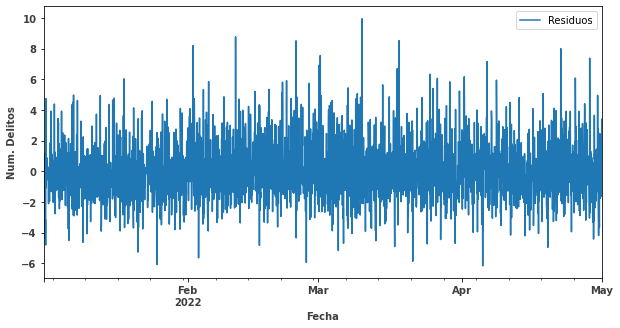

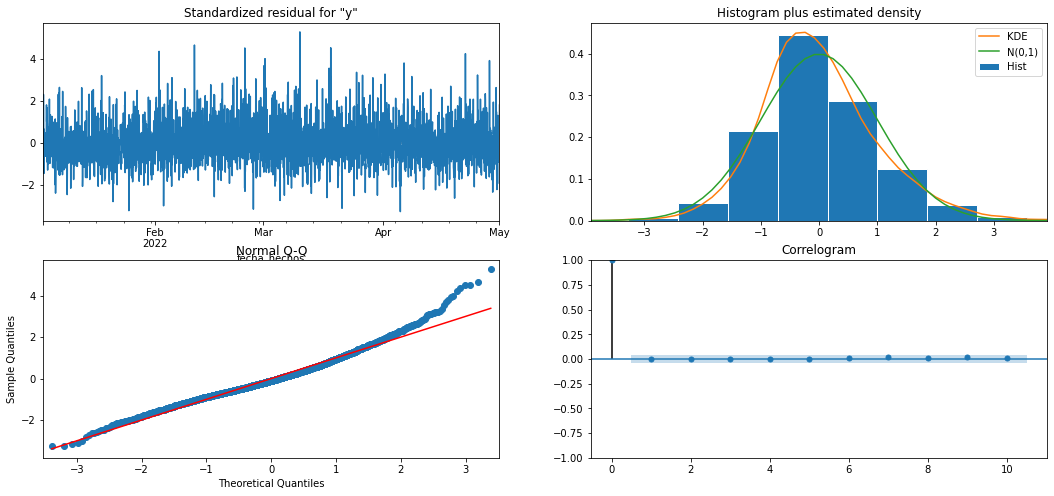

In [59]:
#Residual analysis
ax, fig = plt.subplots(figsize = (10,5))

model.resid.plot(label="Residuos")
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Fecha",alpha=0.75, weight="bold")
plt.ylabel("Num. Delitos",alpha=0.75, weight="bold")
plt.legend()
#plt.text(x=datetime.date(2022, 1, 2), y=7200, s="Analisis reisdual",
#fontsize=15, weight="bold", alpha=0.75)
#plt.text(x=datetime.date(2011, 6, 30), y=6700, s="Analaysis of the residual values for the best model acording to AIC.",fontsize=12, alpha=0.75)
x = model.plot_diagnostics(figsize=(18, 8))
#gc.collect()
del x

In [64]:
test_forecast = model.predict(start=pd.to_datetime(y_test.index[0]), end=pd.to_datetime(y_test.index[-2]),
               exog=sm.add_constant(X_test.iloc[:-1,:]),dynamic=False)
test_forecast[test_forecast<0] = 0

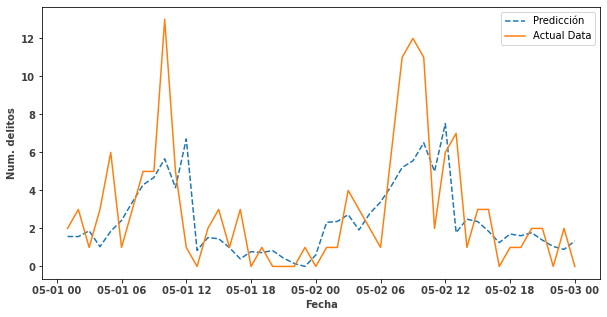

In [66]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(test_forecast[:48], ls="--", label="Predicción")
plt.plot(y_test[:48], label="Actual Data")
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Fecha",alpha=0.75, weight="bold")
plt.ylabel("Num. delitos",alpha=0.75, weight="bold")
plt.legend()
#plt.text(x=datetime.date(2011, 6, 30), y=18000, s="Forcasting test of SARIMAX",
#fontsize=18, weight="bold", alpha=0.75)
#plt.text(x=datetime.date(2011, 6, 30), y=17000, s="Prediction testing of the best SARIMAX model.",fontsize=15, alpha=0.75)
#gc.collect()

In [69]:
print_sarima_results(y_test[:-1], test_forecast)

Test Mean Absolute Error:       1.5791564724887956
Test Root Mean Squared Error:   2.093406579790656


### **Violencia Familiar**

### **Robo transeuntes**

### **Fraude**

# Borrador

**Extracción de  datos**

In [ ]:
delito = FGJ_carpetas[FGJ_carpetas["categoria_delito_homo"] == cat[0]]
if not delito.index.is_monotonic:
    delito = delito.sort_index()
delito.head(4)

fecha_hechos       fecha_hechos.1  \
fecha_hechos                                                   
2016-01-01 00:00:00 2016-01-01 00:00:00  2016-01-01 00:00:00   
2016-01-01 01:45:00 2016-01-01 01:45:00  2016-01-01 01:45:00   
2016-01-01 02:30:00 2016-01-01 02:30:00  2016-01-01 02:30:00   
2016-01-01 07:00:00 2016-01-01 07:00:00  2016-01-01 07:00:00   

                            fecha_inicio           delito  \
fecha_hechos                                                
2016-01-01 00:00:00  2016-05-09 23:14:05          DESPOJO   
2016-01-01 01:45:00  2016-01-02 13:04:22  ROBO DE OBJETOS   
2016-01-01 02:30:00  2016-01-01 12:45:24  ROBO DE OBJETOS   
2016-01-01 07:00:00  2016-01-01 10:36:51  ROBO DE OBJETOS   

                                               fiscalia agencia  \
fecha_hechos                                                      
2016-01-01 00:00:00            INVESTIGACIÓN EN TLALPAN   TLP-3   
2016-01-01 01:45:00           INVESTIGACIÓN EN COYOACÁN   COY-5   
2016-01-01 02:30:00         INVESTIGACIÓN EN CUAUHTEMOC   CUH-5   
2016-01-01 07:00:00  INVESTIGACIÓN EN GUSTAVO A. MADERO   GAM-6   

                    unidad_investigacion        categoria_delito  \
fecha_hechos                                                       
2016-01-01 00:00:00               UI-3CD  DELITO DE BAJO IMPACTO   
2016-01-01 01:45:00               UI-1CD  DELITO DE BAJO IMPACTO   
2016-01-01 02:30:00               UI-3SD  DELITO DE BAJO IMPACTO   
2016-01-01 07:00:00               UI-3CD  DELITO DE BAJO IMPACTO   

                           colonia_hechos   alcaldia_hechos   longitud  \
fecha_hechos                                                             
2016-01-01 00:00:00    SANTO TOMAS AJUSCO           TLALPAN -99.217858   
2016-01-01 01:45:00  SAN LORENZO ATEMOAYA        XOCHIMILCO -99.097561   
2016-01-01 02:30:00                JUÁREZ        CUAUHTEMOC -99.165413   
2016-01-01 07:00:00               VALLEJO  GUSTAVO A MADERO -99.140430   

                       latitud      delito_homo categoria_delito_homo  
fecha_hechos                                                           
2016-01-01 00:00:00  19.212409  ROBO DE OBJETOS       ROBO DE OBJETOS  
2016-01-01 01:45:00  19.238718  ROBO DE OBJETOS       ROBO DE OBJETOS  
2016-01-01 02:30:00  19.425833  ROBO DE OBJETOS       ROBO DE OBJETOS  
2016-01-01 07:00:00  19.466797  ROBO DE OBJETOS       ROBO DE OBJETOS

In [ ]:
delito_h = delito.resample("H", on = "fecha_hechos").size()
plot_dataset(delito_h,cat[0])

**Extracción de caracteristicas**

Creamos columnas que contengan información de la fecha de los registros como el dia de la semana, la hora o ciertas medidas climaticas de esa hora. Recordemos que al realizar el análisis de los daos, el dia de la semana y la hora  mostraron cierto efecto con el numero de delito registrados.

In [ ]:
#Categorias dummies que contienen informacion de la fecha
df_features = onehot_feature(delito_h, ['hour','day_of_week'])
df_features

0  day_of_week_1  day_of_week_2  day_of_week_3  \
fecha_hechos                                                          
2016-01-01 00:00:00  1              0              0              0   
2016-01-01 01:00:00  1              0              0              0   
2016-01-01 02:00:00  1              0              0              0   
2016-01-01 03:00:00  0              0              0              0   
2016-01-01 04:00:00  0              0              0              0   
...                 ..            ...            ...            ...   
2022-06-30 14:00:00  0              0              0              1   
2022-06-30 15:00:00  0              0              0              1   
2022-06-30 16:00:00  0              0              0              1   
2022-06-30 17:00:00  0              0              0              1   
2022-06-30 18:00:00  1              0              0              1   

                     day_of_week_4  day_of_week_5  day_of_week_6  hour_1  \
fecha_hechos                                                               
2016-01-01 00:00:00              1              0              0       0   
2016-01-01 01:00:00              1              0              0       1   
2016-01-01 02:00:00              1              0              0       0   
2016-01-01 03:00:00              1              0              0       0   
2016-01-01 04:00:00              1              0              0       0   
...                            ...            ...            ...     ...   
2022-06-30 14:00:00              0              0              0       0   
2022-06-30 15:00:00              0              0              0       0   
2022-06-30 16:00:00              0              0              0       0   
2022-06-30 17:00:00              0              0              0       0   
2022-06-30 18:00:00              0              0              0       0   

                     hour_2  hour_3  ...  hour_14  hour_15  hour_16  hour_17  \
fecha_hechos                         ...                                       
2016-01-01 00:00:00       0       0  ...        0        0        0        0   
2016-01-01 01:00:00       0       0  ...        0        0        0        0   
2016-01-01 02:00:00       1       0  ...        0        0        0        0   
2016-01-01 03:00:00       0       1  ...        0        0        0        0   
2016-01-01 04:00:00       0       0  ...        0        0        0        0   
...                     ...     ...  ...      ...      ...      ...      ...   
2022-06-30 14:00:00       0       0  ...        1        0        0        0   
2022-06-30 15:00:00       0       0  ...        0        1        0        0   
2022-06-30 16:00:00       0       0  ...        0        0        1        0   
2022-06-30 17:00:00       0       0  ...        0        0        0        1   
2022-06-30 18:00:00       0       0  ...        0        0        0        0   

                     hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  
fecha_hechos                                                               
2016-01-01 00:00:00        0        0        0        0        0        0  
2016-01-01 01:00:00        0        0        0        0        0        0  
2016-01-01 02:00:00        0        0        0        0        0        0  
2016-01-01 03:00:00        0        0        0        0        0        0  
2016-01-01 04:00:00        0        0        0        0        0        0  
...                      ...      ...      ...      ...      ...      ...  
2022-06-30 14:00:00        0        0        0        0        0        0  
2022-06-30 15:00:00        0        0        0        0        0        0  
2022-06-30 16:00:00        0        0        0        0        0        0  
2022-06-30 17:00:00        0        0        0        0        0        0  
2022-06-30 18:00:00        1        0        0        0        0        0  

[56947 rows x 30 columns]

In [ ]:
#Distincion de fechas festivas
mx_holidays = holidays.MEX()

df_features = add_holiday_col(df_features, mx_holidays)
df_features

0  day_of_week_1  day_of_week_2  day_of_week_3  \
fecha_hechos                                                          
2016-01-01 00:00:00  1              0              0              0   
2016-01-01 01:00:00  1              0              0              0   
2016-01-01 02:00:00  1              0              0              0   
2016-01-01 03:00:00  0              0              0              0   
2016-01-01 04:00:00  0              0              0              0   
...                 ..            ...            ...            ...   
2022-06-30 14:00:00  0              0              0              1   
2022-06-30 15:00:00  0              0              0              1   
2022-06-30 16:00:00  0              0              0              1   
2022-06-30 17:00:00  0              0              0              1   
2022-06-30 18:00:00  1              0              0              1   

                     day_of_week_4  day_of_week_5  day_of_week_6  hour_1  \
fecha_hechos                                                               
2016-01-01 00:00:00              1              0              0       0   
2016-01-01 01:00:00              1              0              0       1   
2016-01-01 02:00:00              1              0              0       0   
2016-01-01 03:00:00              1              0              0       0   
2016-01-01 04:00:00              1              0              0       0   
...                            ...            ...            ...     ...   
2022-06-30 14:00:00              0              0              0       0   
2022-06-30 15:00:00              0              0              0       0   
2022-06-30 16:00:00              0              0              0       0   
2022-06-30 17:00:00              0              0              0       0   
2022-06-30 18:00:00              0              0              0       0   

                     hour_2  hour_3  ...  hour_15  hour_16  hour_17  hour_18  \
fecha_hechos                         ...                                       
2016-01-01 00:00:00       0       0  ...        0        0        0        0   
2016-01-01 01:00:00       0       0  ...        0        0        0        0   
2016-01-01 02:00:00       1       0  ...        0        0        0        0   
2016-01-01 03:00:00       0       1  ...        0        0        0        0   
2016-01-01 04:00:00       0       0  ...        0        0        0        0   
...                     ...     ...  ...      ...      ...      ...      ...   
2022-06-30 14:00:00       0       0  ...        0        0        0        0   
2022-06-30 15:00:00       0       0  ...        1        0        0        0   
2022-06-30 16:00:00       0       0  ...        0        1        0        0   
2022-06-30 17:00:00       0       0  ...        0        0        1        0   
2022-06-30 18:00:00       0       0  ...        0        0        0        1   

                     hour_19  hour_20  hour_21  hour_22  hour_23  is_holiday  
fecha_hechos                                                                  
2016-01-01 00:00:00        0        0        0        0        0           1  
2016-01-01 01:00:00        0        0        0        0        0           1  
2016-01-01 02:00:00        0        0        0        0        0           1  
2016-01-01 03:00:00        0        0        0        0        0           1  
2016-01-01 04:00:00        0        0        0        0        0           1  
...                      ...      ...      ...      ...      ...         ...  
2022-06-30 14:00:00        0        0        0        0        0           0  
2022-06-30 15:00:00        0        0        0        0        0           0  
2022-06-30 16:00:00        0        0        0        0        0           0  
2022-06-30 17:00:00        0        0        0        0        0           0  
2022-06-30 18:00:00        0        0        0        0        0           0  

[56947 rows x 31 columns]

**Caracteristicas adicionales**

In [ ]:
#Medidas de variables climaticas
place = Point(19.4284700, -99.1276600)
data = Hourly(place, datetime(2016,1,1), datetime(2022,6,30))
data = data.fetch()

In [ ]:
#Numero de delitos rezagados
lag_ts = generate_time_lags(delito_h, 7)
lag_ts

0  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7
fecha_hechos                                                           
2016-01-01 07:00:00  1    0.0    0.0    0.0    0.0    1.0    1.0    1.0
2016-01-01 08:00:00  1    1.0    0.0    0.0    0.0    0.0    1.0    1.0
2016-01-01 09:00:00  3    1.0    1.0    0.0    0.0    0.0    0.0    1.0
2016-01-01 10:00:00  4    3.0    1.0    1.0    0.0    0.0    0.0    0.0
2016-01-01 11:00:00  3    4.0    3.0    1.0    1.0    0.0    0.0    0.0
...                 ..    ...    ...    ...    ...    ...    ...    ...
2022-06-30 14:00:00  0    0.0    0.0    2.0    1.0    0.0    4.0    2.0
2022-06-30 15:00:00  0    0.0    0.0    0.0    2.0    1.0    0.0    4.0
2022-06-30 16:00:00  0    0.0    0.0    0.0    0.0    2.0    1.0    0.0
2022-06-30 17:00:00  0    0.0    0.0    0.0    0.0    0.0    2.0    1.0
2022-06-30 18:00:00  1    0.0    0.0    0.0    0.0    0.0    0.0    2.0

[56940 rows x 8 columns]

**Ajuste de modelo lineal**

In [ ]:
#ts_train_delito=delito_h[delito_h.index<'2022']
#ts_test_delito=delito_h[delito_h.index>='2022']
#
X_train = df_features.iloc[delito_h.index<'2021-05',1:]
y_train = df_features.iloc[delito_h.index<'2021-05',0]
X_val = df_features.iloc[(delito_h.index>='2021-05')&(delito_h.index<='2022-05'),1:]
y_val = df_features.iloc[(delito_h.index>='2021-05')&(delito_h.index<='2022-05'),0]

X_test = df_features.iloc[delito_h.index>'2022-05',1:]
y_test = df_features.iloc[delito_h.index>'2022-05',0]

In [ ]:
'''model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)'''

X2 = sm.add_constant(X_train)
model = sm.OLS(y_train, X2)
model = model.fit()
print(model.summary())

result = pd.DataFrame({'value':y_test})
result["prediction"] = prediction
result = result.sort_index()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     803.6
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        09:10:21   Log-Likelihood:            -1.0215e+05
No. Observations:               46728   AIC:                         2.044e+05
Df Residuals:                   46697   BIC:                         2.046e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8442      0.055     33.629

In [ ]:
result

value  prediction
fecha_hechos                          
2022-05-01 01:00:00      2    0.251231
2022-05-01 02:00:00      3    0.330840
2022-05-01 03:00:00      1    0.439726
2022-05-01 04:00:00      3    0.247122
2022-05-01 05:00:00      6    0.666228
...                    ...         ...
2022-06-30 14:00:00      0    4.165052
2022-06-30 15:00:00      0    4.153753
2022-06-30 16:00:00      0    3.653496
2022-06-30 17:00:00      0    3.394636
2022-06-30 18:00:00      1    3.610866

[1458 rows x 2 columns]

In [ ]:
baseline_metrics = calculate_metrics(result)
print(baseline_metrics)

{'mae': 1.9110330367096746, 'rmse': 2.431440886046107, 'r2': 0.205489203488607}


**Residuales**

<AxesSubplot:xlabel='fecha_hechos'>

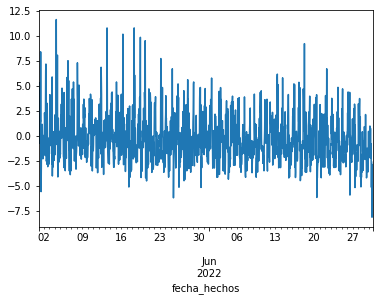

In [ ]:
residuos = y_test-prediction
residuos.plot()

In [ ]:
#Prueba de estacionalidad
dftest = adfuller(result.value, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])

1. ADF :  -3.891987757592379
2. P-Value :  0.0020946104843951974


C:\Users\110395\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



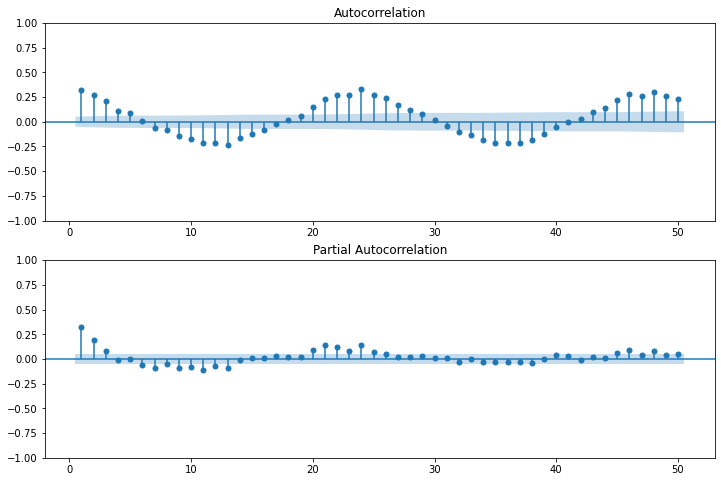

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(residuos, lags=50, zero=False, ax=ax1)
plot_pacf(residuos, lags=50, zero=False, ax=ax2)

plt.show()

In [ ]:
pm.auto_arima(residuos,seasonal=True,m=24)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 24),
      suppress_warnings=True, with_intercept=False)

In [ ]:

'''    #Applying Sarimax on demand data with exogenance variables on Cluster
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        train_data = pd.DataFrame(train['demand'])
        train_exog = train.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]
        test_data = pd.DataFrame(test['demand'])
        test_exog = test.loc[:,['hour','day'	,'dayofweek',	'temperature',	'wind_speed']]


        order,seasonal_order = get_sarima_params(train_data)
        train_forecast, test_forecast = apply_sarima(train_data,train_exog,test_data,test_exog,order,seasonal_order)  

        #Ignoring test data between 23-26 Jan 2016
        test_cleaned = test_data.drop(indexes) 
        test_forecast_cleaned = test_forecast.drop(indexes)

        print_sarima_results(train_data,test_cleaned,train_forecast, test_forecast_cleaned)


    result_df = pd.DataFrame(test)
    result_df['predicted_value'] = test_forecast

    # Prediction visualization using plotly
    from plotly.offline import init_notebook_mode, iplot
    iplot([{
        'x': result_df.index,
        'y': result_df[col],
        'name': col
    }  for col in result_df.loc[:,['demand','predicted_value']].columns])
    '''

'    #Applying Sarimax on demand data with exogenance variables on Cluster\n    with warnings.catch_warnings():\n        warnings.simplefilter("ignore")\n\n        train_data = pd.DataFrame(train[\'demand\'])\n        train_exog = train.loc[:,[\'hour\',\'day\'\t,\'dayofweek\',\t\'temperature\',\t\'wind_speed\']]\n        test_data = pd.DataFrame(test[\'demand\'])\n        test_exog = test.loc[:,[\'hour\',\'day\'\t,\'dayofweek\',\t\'temperature\',\t\'wind_speed\']]\n\n\n        order,seasonal_order = get_sarima_params(train_data)\n        train_forecast, test_forecast = apply_sarima(train_data,train_exog,test_data,test_exog,order,seasonal_order)  \n\n        #Ignoring test data between 23-26 Jan 2016\n        test_cleaned = test_data.drop(indexes) \n        test_forecast_cleaned = test_forecast.drop(indexes)\n\n        print_sarima_results(train_data,test_cleaned,train_forecast, test_forecast_cleaned)\n\n\n    result_df = pd.DataFrame(test)\n    result_df[\'predicted_value\'] = test_for